In [360]:
import torch
import torch.nn.functional as F

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [361]:
words = pd.read_csv("https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt")
words = words.values
words = words.reshape(1,-1).squeeze()
words

array(['olivia', 'ava', 'isabella', ..., 'zyrie', 'zyron', 'zzyzx'],
      shape=(32032,), dtype=object)

In [362]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [363]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train,  y_train  = build_dataset(words[:n1])     # 80%
X_val, y_val = build_dataset(words[n1:n2])   # 10%
X_test,  y_test  = build_dataset(words[n2:])     # 10%

torch.Size([182436, 3]) torch.Size([182436])
torch.Size([22844, 3]) torch.Size([22844])
torch.Size([22861, 3]) torch.Size([22861])


In [364]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [365]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [366]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
Xb, Yb = X_train[ix], y_train[ix] # batch X,Y

In [367]:
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], -1)

h_pre_bn = emb_cat @ W1 + b1

bn_meani = 1 / n * h_pre_bn.sum(0, keepdim=True)
bn_diff = h_pre_bn - bn_meani
bn_diff2 = bn_diff ** 2
bn_var = 1 / (n-1) * (bn_diff2).sum(0, keepdim=True)
bn_var_inv = (bn_var + 1e-5) **-0.5

bn_raw = bn_diff * bn_var_inv
hpreact = bngain * bn_raw + bnbias

h = torch.tanh(hpreact)
logits = h @ W2 + b2

logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes

counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1

probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, hpreact, bn_raw, bn_var_inv, bn_var, bn_diff2, bn_diff, h_pre_bn, bn_meani, emb_cat, emb]:
    t.retain_grad()

loss.backward()
loss

tensor(3.5127, grad_fn=<NegBackward0>)

In [368]:
h_pre_bn.shape

torch.Size([32, 64])

In [369]:
hpreact.shape

torch.Size([32, 64])

# Exercise 1

In [370]:
# dloss/dlogprobs

# simple example

# mean = (a + b + c)/3 = a/3 + b/3 + c/3
# loss =  -mean =  -1/3 a - 1/3 b - 1/3 c

# dloss/da = -1/3

# if a vector's lenght is n, so

# dloss/dvector = -1/n

# but before that we have a matrix of probabilities, and those cells that didn't included in making a loss, their derivatives equal zero

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n


In [371]:
# dloss/dprobs = dloss/dlogprobs * dlogprobs/dprobs 

# y = ln(x)
# dy/dx = 1/(x*ln(e)) = 1/x

dprobs = 1.0 / probs * dlogprobs



In [372]:
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdim=True)
# counts_sum_inv = counts_sum**-1

# probs = counts * counts_sum_inv

In [373]:
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts_sum_inv.shape

torch.Size([32, 1])

In [374]:
counts_sum.shape

torch.Size([32, 1])

In [375]:
dcounts_sum = -(counts_sum**-2) * dcounts_sum_inv
dcounts_sum.shape

torch.Size([32, 1])

In [376]:
dcounts1 = torch.ones_like(counts) * dcounts_sum
dcounts2 = counts_sum_inv * dprobs
dcounts = dcounts1 + dcounts2
dcounts.shape

torch.Size([32, 27])

In [377]:
# h = torch.tanh(hpreact)
# logits = h @ W2 + b2

# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes

# counts = norm_logits.exp()

In [378]:
dnorm_logits = norm_logits.exp() * dcounts
dnorm_logits.shape

torch.Size([32, 27])

In [379]:
logits.shape

torch.Size([32, 27])

In [380]:
logit_maxes.shape

torch.Size([32, 1])

In [381]:
dnorm_logits.shape

torch.Size([32, 27])

In [382]:
# [a, b, c] - [max(a,b,c)] =[a-max(a,b,c) b-max(a,b,c) c-max(a,b,c)]
# [1, 2, 3] - [3]

In [383]:

dlogit_maxes = -1.0 * dnorm_logits.sum(1, keepdim=True)
dlogit_maxes.shape

torch.Size([32, 1])

In [384]:
dlogits = dnorm_logits.clone() # (32, 27)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dlogits.shape

torch.Size([32, 27])

In [385]:
# hpreact = bngain * bn_raw + bnbias

# h = torch.tanh(hpreact)
# logits = h @ W2 + b2

In [386]:
b2.shape

torch.Size([27])

In [387]:
h.shape

torch.Size([32, 64])

In [388]:
dh = dlogits @ W2.T
dh.shape

torch.Size([32, 64])

In [389]:
dW2 = h.T @ dlogits
W2.shape, dW2.shape

(torch.Size([64, 27]), torch.Size([64, 27]))

In [390]:
db2 = dlogits.sum(0)
db2.shape, b2.shape

(torch.Size([27]), torch.Size([27]))

In [391]:

# hpreact = bngain * bn_raw + bnbias

# h = torch.tanh(hpreact)

In [392]:
dhpreact = (1.0 - h**2) * dh
dhpreact.shape, hpreact.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [393]:
bn_raw.shape

torch.Size([32, 64])

In [394]:
bngain.shape, bnbias.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

In [395]:
dbnraw = bngain * dhpreact
dbnraw.shape, bn_raw.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [396]:
dbngain = (bn_raw * dhpreact).sum(0, keepdim=True)
dbngain.shape

torch.Size([1, 64])

In [397]:
dbnbias = dhpreact.sum(0, keepdim=True)
dbnbias.shape

torch.Size([1, 64])

In [398]:
# bn_diff2 = bn_diff ** 2
# bn_var = 1 / (n-1) * (bn_diff2).sum(0, keepdim=True)
# bn_var_inv = (bn_var + 1e-5) **-0.5

# bn_raw = bn_diff * bn_var_inv

In [399]:
bn_diff.shape, bn_var_inv.shape

(torch.Size([32, 64]), torch.Size([1, 64]))

In [400]:
dbnvar_inv = (bn_diff * dbnraw).sum(0,keepdim=True)
dbnvar_inv.shape

torch.Size([1, 64])

In [401]:
dbndiff1_1 = (dbnraw * bn_var_inv)
dbndiff1_1.shape


torch.Size([32, 64])

In [402]:
dbnvar = -0.5 * (bn_var + 1e-5)**(-1.5) * dbnvar_inv
dbnvar.shape,  bn_var.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

In [403]:
bn_diff2.shape

torch.Size([32, 64])

In [404]:
dbndiff2 = torch.ones_like(bn_diff2) * dbnvar * (n-1.0)**-1
dbndiff2.shape

torch.Size([32, 64])

In [405]:
dbndiff1_2 = 2 * bn_diff * dbndiff2
dbndiff = dbndiff1_1 + dbndiff1_2
dbndiff.shape, bn_diff.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [406]:
# bn_meani = 1 / n * h_pre_bn.sum(0, keepdim=True)
# bn_diff = h_pre_bn - bn_meani

In [407]:
h_pre_bn.shape, bn_meani.shape

(torch.Size([32, 64]), torch.Size([1, 64]))

In [408]:
dbnmeani = -dbndiff.sum(0, keepdim=True)
dbnmeani.shape

torch.Size([1, 64])

In [409]:
dhprebn1 = dbndiff.clone()
dhprebn2 = torch.ones_like(h_pre_bn) * dbnmeani * 1.0 / n
dhprebn = dhprebn1 + dhprebn2
dhprebn.shape

torch.Size([32, 64])

In [410]:
# emb = C[Xb]
# emb_cat = emb.view(emb.shape[0], -1)

# h_pre_bn = emb_cat @ W1 + b1


In [411]:
emb_cat.shape, W1.shape, b1.shape

(torch.Size([32, 30]), torch.Size([30, 64]), torch.Size([64]))

In [412]:
dembcat = dhprebn @ W1.T
dembcat.shape

torch.Size([32, 30])

In [413]:
dW1 = emb_cat.T @ dhprebn
W1.shape, dW1.shape

(torch.Size([30, 64]), torch.Size([30, 64]))

In [414]:
db1 = dhprebn.sum(0)
db1.shape, b1.shape

(torch.Size([64]), torch.Size([64]))

In [415]:
emb_cat.shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 3, 10]))

In [416]:
demb = dembcat.view(n, block_size, n_embd).clone()
demb.shape

torch.Size([32, 3, 10])

In [417]:
C.shape, Xb.shape, emb.shape

(torch.Size([27, 10]), torch.Size([32, 3]), torch.Size([32, 3, 10]))

In [418]:
Xb

tensor([[ 0,  0,  0],
        [18,  9, 19],
        [21, 18,  9],
        [12,  5, 25],
        [ 0,  4,  1],
        [ 0, 11,  9],
        [ 0, 19,  8],
        [ 1, 12,  9],
        [ 5, 12,  1],
        [ 1, 14, 14],
        [ 0,  0,  0],
        [14,  1,  8],
        [12,  9,  5],
        [11, 25, 12],
        [ 0,  1, 18],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0, 19, 21],
        [ 1,  9, 22],
        [ 2,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  8],
        [ 0,  0,  0],
        [ 0, 26,  1],
        [19,  8,  9],
        [ 4,  1, 14],
        [ 0, 17, 21],
        [ 0,  1, 11],
        [ 0,  0,  0],
        [ 8, 13,  1],
        [13,  5,  7],
        [ 5, 19,  8]])

In [419]:
demb[:1]

tensor([[[ 4.1634e-03, -4.8184e-03, -9.4746e-04,  2.6319e-03, -1.3182e-02,
           4.0394e-03,  3.0738e-03, -9.1280e-03, -5.3464e-03,  1.7744e-04],
         [-7.0255e-03, -5.9885e-03,  8.7900e-05, -4.6602e-03,  1.9324e-03,
           2.3387e-04, -7.9986e-03, -2.2459e-05, -2.4662e-03, -1.1026e-04],
         [ 3.0057e-03,  9.2972e-03, -9.4630e-03,  9.8680e-04, -2.9009e-03,
           9.1980e-04,  3.4469e-03, -1.7078e-03,  6.9006e-03, -7.1560e-03]]],
       grad_fn=<SliceBackward0>)

In [420]:
dC = torch.zeros_like(C)

for j in range(Xb.shape[0]):
    for k in range(Xb.shape[1]):
        ix = Xb[j,k]
        dC[ix] += demb[j,k] # shape (10)

In [421]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bn_raw)
cmp('bnvar_inv', dbnvar_inv, bn_var_inv)
cmp('bnvar', dbnvar, bn_var)
cmp('bndiff2', dbndiff2, bn_diff2)
cmp('bndiff', dbndiff, bn_diff)
cmp('bnmeani', dbnmeani, bn_meani)
cmp('hprebn', dhprebn, h_pre_bn)
cmp('embcat', dembcat, emb_cat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

# Exercise 2

In [422]:
# logits = h @ W2 + b2

# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes

# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdim=True)
# counts_sum_inv = counts_sum**-1

# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

loss_fast = F.cross_entropy(logits, Yb)
loss_fast

tensor(3.5127, grad_fn=<NllLossBackward0>)

In [423]:
# cross_entropy = -log(softmax(x)[ix(the row with probabilities)])

softmax_pytorch = F.softmax(logits, dim=1)

up_part = logits.exp()
down_part = logits.exp().sum(1, keepdim=True)

my_softmax = up_part * down_part**-1

my_softmax[:1]

tensor([[0.0207, 0.0132, 0.0515, 0.0150, 0.0454, 0.0134, 0.0594, 0.0350, 0.0517,
         0.0432, 0.0185, 0.0296, 0.0338, 0.0360, 0.0220, 0.0472, 0.0973, 0.0391,
         0.0460, 0.0235, 0.0472, 0.0295, 0.0972, 0.0114, 0.0215, 0.0252, 0.0266]],
       grad_fn=<SliceBackward0>)

In [424]:
Yb

tensor([20, 20, 14,  0, 12, 18,  5,  5, 14,  1, 19,  0,  0,  1, 20,  1, 13,  3,
         1,  8,  1,  5, 13,  1, 22, 14,  9, 15,  9, 14, 25,  1])

In [425]:
my_softmax

softmax_ranged = my_softmax[range(n), Yb]

log_softmax_ranged = softmax_ranged.log()
print(-log_softmax_ranged.mean())

# loss = -(logits.exp()/logits.exp().sum(1, keepdim=True))[range(n), Yb].log().mean()



tensor(3.5127, grad_fn=<NegBackward0>)


In [426]:
softmax_ranged.shape

torch.Size([32])

In [427]:
dlog_softmax_ranged = -1.0/n
dsoftmax_ranged = softmax_ranged**-1 * dlog_softmax_ranged

dmy_softmax = torch.ones_like(my_softmax)
dmy_softmax[range(n), Yb] *= dsoftmax_ranged

dlogits = (logits.exp() * logits.exp().sum(1, keepdim=True) - logits.exp()**2)/(logits.exp().sum(1, keepdim=True)** 2) * dmy_softmax

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: False | maxdiff: 0.13325996696949005


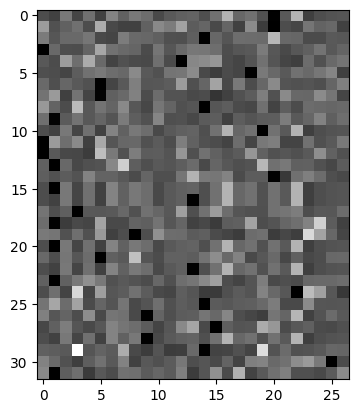

In [428]:
plt.imshow(dlogits.detach(),cmap="gray")

In [429]:
Yb

tensor([20, 20, 14,  0, 12, 18,  5,  5, 14,  1, 19,  0,  0,  1, 20,  1, 13,  3,
         1,  8,  1,  5, 13,  1, 22, 14,  9, 15,  9, 14, 25,  1])

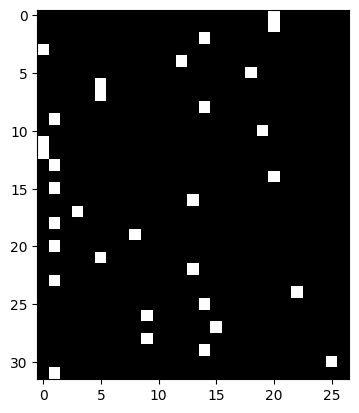

In [430]:
plt.imshow(F.one_hot(Yb, num_classes=27), cmap="gray")

In [ ]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.28642737865448e-09


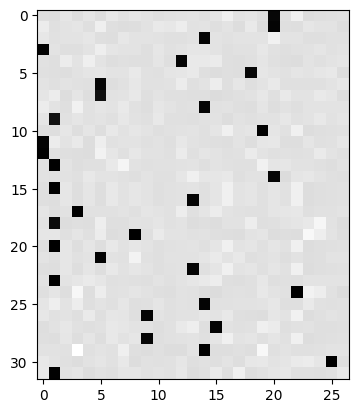

In [432]:
plt.imshow(dlogits.detach(),cmap="gray")

# Exercise 3

#### batch normalization layer

In [433]:
# h_pre_bn = emb_cat @ W1 + b1

# bn_meani = 1 / n * h_pre_bn.sum(0, keepdim=True)
# bn_diff = h_pre_bn - bn_meani
# bn_diff2 = bn_diff ** 2
# bn_var = 1 / (n-1) * (bn_diff2).sum(0, keepdim=True)
# bn_var_inv = (bn_var + 1e-5) **-0.5

# bn_raw = bn_diff * bn_var_inv
# hpreact = bngain * bn_raw + bnbias

In [434]:
hpreact.shape

torch.Size([32, 64])

In [435]:
dhprebn.shape

torch.Size([32, 64])

In [437]:
dhprebn = bngain * bn_var_inv / n * (n * dhpreact - dhpreact.sum(0) -  n / (n-1) * bn_raw * (dhpreact * bn_raw).sum(0))

cmp("hprebn", dhprebn, h_pre_bn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


# Exarcise 4

In [503]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 20000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

# kick off optimization
  for i in range(max_steps):  

    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], y_train[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    # loss.backward() # use this for correctness comparisons, delete it later!



    # manual backprop! #swole_doge_meme

    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n

    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)

    dhpreact = (1.0 - h**2) * dh
    
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

    # dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------




    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 1000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #   break

12297
      0/  20000: 3.9289
   1000/  20000: 2.7122
   2000/  20000: 2.2775
   3000/  20000: 1.9367
   4000/  20000: 2.0192
   5000/  20000: 2.3834
   6000/  20000: 2.2044
   7000/  20000: 2.1855
   8000/  20000: 2.3155
   9000/  20000: 2.3631
  10000/  20000: 2.3405
  11000/  20000: 2.4811
  12000/  20000: 1.9902
  13000/  20000: 2.7938
  14000/  20000: 2.3828
  15000/  20000: 1.8885
  16000/  20000: 2.4529
  17000/  20000: 2.1717
  18000/  20000: 1.9894
  19000/  20000: 2.1222


In [504]:
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

TypeError: all() received an invalid combination of arguments - got (bool), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, tuple of ints dim = None, bool keepdim = False, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, Tensor out = None)
 * (Tensor input, name dim, bool keepdim = False, *, Tensor out = None)


In [501]:


# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[X_train]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)



In [508]:


# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, y_train),
    'val': (X_val, y_val),
    'test': (X_test, y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())


split_loss('train')
split_loss('val')



train 2.23178768157959
val 2.264627695083618


In [509]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carla.
zameril.
khiemleige.
tylena.
sane.
mahnel.
ameryac.
areeigh.
amari.
chaiivon.
leigh.
ham.
jois.
quinn.
shoilea.
jadbi.
watell.
dearyxir.
kaellissa.
mel.
